In [10]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

Preprocessing

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [11]:
train_dir = 'processed_images'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [12]:
def create_model(optimizer='adam', init_mode='uniform', dropout_rate=0.5, filters1=32, filters2=64, dense_units=128):
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(Conv2D(filters=int(filters1), kernel_size=(3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=int(filters2), kernel_size=(3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=int(dense_units), activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [13]:
def model_train_evaluate(optimizer, init_mode, dropout_rate, filters1, filters2, dense_units):
    model = create_model(optimizer=optimizer, init_mode=init_mode, dropout_rate=dropout_rate, filters1=filters1, filters2=filters2, dense_units=dense_units)
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        verbose=0
    )
    
    val_loss, val_acc = model.evaluate(test_generator, verbose=0)
    return val_acc

def optimize_model():
    optimizer_dict = {
        'SGD': SGD,
        'Adam': Adam
    }
    
    def model_wrapper(optimizer, init_mode, dropout_rate, filters1, filters2, dense_units):
        optimizer_str = 'SGD' if optimizer < 0.5 else 'Adam'
        return model_train_evaluate(
            optimizer=optimizer_dict[optimizer_str](),
            init_mode='uniform' if init_mode < 0.5 else 'he_normal',
            dropout_rate=dropout_rate,
            filters1=filters1,
            filters2=filters2,
            dense_units=dense_units
        )
    
    pbounds = {
        'optimizer': (0, 1),
        'init_mode': (0, 1),
        'dropout_rate': (0.3, 0.7),
        'filters1': (16, 64),
        'filters2': (32, 128),
        'dense_units': (64, 256)
    }
    
    optimizer = BayesianOptimization(
        f=model_wrapper,
        pbounds=pbounds,
        random_state=1
    )
    
    optimizer.maximize(init_points=2, n_iter=3)
    
    print("Best hyperparameters found: ", optimizer.max)
    return optimizer.max

In [14]:
best_params = optimize_model()

# Create and evaluate the best model
best_model = create_model(
    optimizer=SGD() if best_params['params']['optimizer'] < 0.5 else Adam(),
    init_mode='uniform' if best_params['params']['init_mode'] < 0.5 else 'he_normal',
    dropout_rate=best_params['params']['dropout_rate'],
    filters1=int(best_params['params']['filters1']),
    filters2=int(best_params['params']['filters2']),
    dense_units=int(best_params['params']['dense_units'])
)

history = best_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

|   iter    |  target   | dense_... | dropou... | filters1  | filters2  | init_mode | optimizer |
-------------------------------------------------------------------------------------------------


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


| 1         | 0.301     | 144.1     | 0.5881    | 16.01     | 61.02     | 0.1468    | 0.09234   |
| 2         | 0.5295    | 99.76     | 0.4382    | 35.04     | 83.73     | 0.4192    | 0.6852    |
| 3         | 0.5057    | 98.46     | 0.4588    | 34.97     | 83.79     | 0.3333    | 0.6186    |
| 4         | 0.5248    | 109.7     | 0.3165    | 35.63     | 83.26     | 0.9298    | 0.9843    |
| 5         | 0.6067    | 105.5     | 0.3       | 30.58     | 93.0      | 1.0       | 1.0       |
Best hyperparameters found:  {'target': 0.6066666841506958, 'params': {'dense_units': 105.49196362040566, 'dropout_rate': 0.3, 'filters1': 30.583139782511623, 'filters2': 93.00304462537339, 'init_mode': 1.0, 'optimizer': 1.0}}
Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 150s 448ms/step - accuracy: 0.0441 - loss: 9.9369 - val_accuracy: 0.0476 - val_loss: 3.0445
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 149s 450ms/step - accuracy: 0.0443 - loss: 3.0447 - val_accuracy: 0.0476 - val_loss: 3.0445
Epoch 3/10
329/329 

Evaluate Model

In [15]:
# Evaluate the model
train_loss, train_acc = best_model.evaluate(train_generator)
val_loss, val_acc = best_model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {val_acc:.4f}')

329/329 ━━━━━━━━━━━━━━━━━━━━ 70s 210ms/step - accuracy: 0.0457 - loss: 3.0446
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.0570 - loss: 3.0444
Train accuracy: 0.0476, Test accuracy: 0.0476


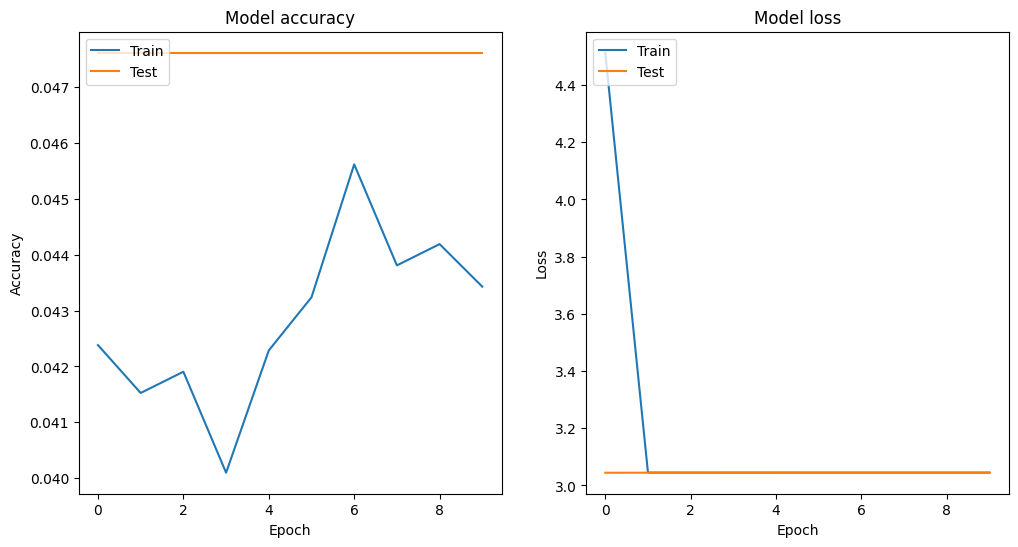

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & Test loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
